In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys, glob, tqdm
import _pickle as pkl

## load the data

In [5]:
# path = '/Volumes/s1/test/NIDAQ_TEST_g0/'
path='/Volumes/s1/color_representation/20200703_C9_BC_g0/'

In [6]:
glob.glob(path+'*bin')

['/Volumes/s1/color_representation/20200703_C9_BC_g0/20200703_C9_BC_g0_t0.nidq.bin']

In [7]:
mm = np.memmap(glob.glob(path+'*bin')[0],dtype=np.uint16)

get just the digital lines

In [8]:
digital_words = mm[8::9] # there are 9 NI channels; the last is the digital words. start at the 9th entry (the digital words) and get every 9th

In [9]:
print(digital_words.shape[0]/1000000)

5756.488941


## parse into binary lines
from https://stackoverflow.com/questions/10411085/converting-integer-to-binary-in-python
<br>examples (1 means a line is high, 0 means it is low):

In [10]:
'{0:08b}'.format(digital_words[:600040][0])

'01110000'

In [11]:
'{0:08b}'.format(digital_words[:64][1])

'01110000'

go through each timepoint and figure out if each line has switched states (high --> low or low --> high). the output will be two dictionaries ```digital_lines_rising``` and ```digital_lines_falling```, which have each _sample_ where the transition happened

In [12]:
num_digital_channels=8 # TODO: update to get this from .meta file; from niXDChans
digital_lines_rising = {}
digital_lines_falling = {}
for i in tqdm.tqdm(range(digital_words.shape[0])[::10]): #note that this downsamples by factor 10, to 100kHz
    if i==0:
        state_previous_sample = '{0:08b}'.format(digital_words[i])
        for line in range(num_digital_channels):
            digital_lines_rising['D'+str(line)] = [] #initialize empty list
            digital_lines_falling['D'+str(line)] = [] #initialize empty list
    else:
        state_this_sample = '{0:08b}'.format(digital_words[i])
        changes = [j for j in range(len(state_previous_sample)) if state_previous_sample[j] != state_this_sample[j]]
        for line in changes:   
                if state_this_sample[line] == '1':
                    digital_lines_rising['D'+str(line)].extend([i*10]) #note that this scales back up to 1MHz sampling rate 
                else:
                    digital_lines_falling['D'+str(line)].extend([i*10])  #note that this scales back up to 1MHz sampling rate 
        state_previous_sample=state_this_sample #update sample

  9%|▉         | 51040665/575648895 [14:55<2:14:49, 64852.10it/s] 

KeyboardInterrupt: 

  9%|▉         | 51040665/575648895 [15:13<2:14:49, 64852.10it/s]

reorder manually this time because i had it backwards

In [28]:
digital_lines_rising2 = {}
digital_lines_falling2 = {}
for i,key in enumerate(digital_lines_rising.keys()):
    digital_lines_rising2['D'+str(7-i)]=digital_lines_rising[key]
    digital_lines_falling2['D'+str(7-i)]=digital_lines_falling[key]
    

In [76]:
pkl.dump(digital_lines_rising2,open(os.path.join(path,'digital_lines_rising_samples.pkl'),'wb'))
pkl.dump(digital_lines_falling2,open(os.path.join(path,'digital_lines_falling_samples.pkl'),'wb'))

## check the outputs

In [ ]:
#digital_lines_rising = pkl.load(open(os.path.join(path,'digital_lines_rising_samples.pkl'),'wb'))

In [33]:
digital_lines_rising2.keys()

dict_keys(['D7', 'D6', 'D5', 'D4', 'D3', 'D2', 'D1', 'D0'])

In [37]:
np.array(digital_lines_rising2['D2']).shape

(294001,)

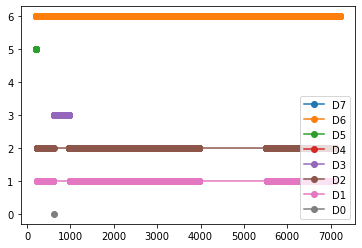

In [73]:
for i,line in enumerate(digital_lines_rising2.keys()):
    plt.plot(np.array(digital_lines_rising2[line])/1e7,np.ones(len(digital_lines_rising2[line]))*(7-i),'-o',label=line)
plt.legend(loc='lower right')


In [75]:
np.array(digital_lines_rising2[line]).shape

(7201,)

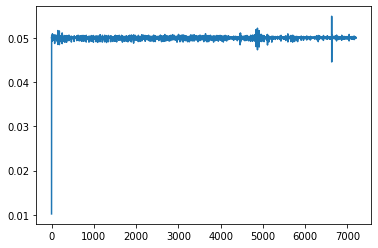

In [74]:
line='D3'
plt.plot(np.diff(np.array(digital_lines_rising2[line])/1e7))